<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cement                         1030 non-null   float64
 1   blast_furnace_slag             1030 non-null   float64
 2   fly_ash                        1030 non-null   float64
 3   water                          1030 non-null   float64
 4   superplasticizer               1030 non-null   float64
 5   coarse_aggregate               1030 non-null   float64
 6   fine_aggregate                 1030 non-null   float64
 7   age                            1030 non-null   int64  
 8   concrete_compressive_strength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB

Starting Training for Concrete Strength Predictor...
Epoch [1/100], Train Loss: 30059.05, Val Loss: 766.76, Val RMSE: $27.69
Epoch [11/100], Train Loss: 120.89, Val Loss: 112.97, Val

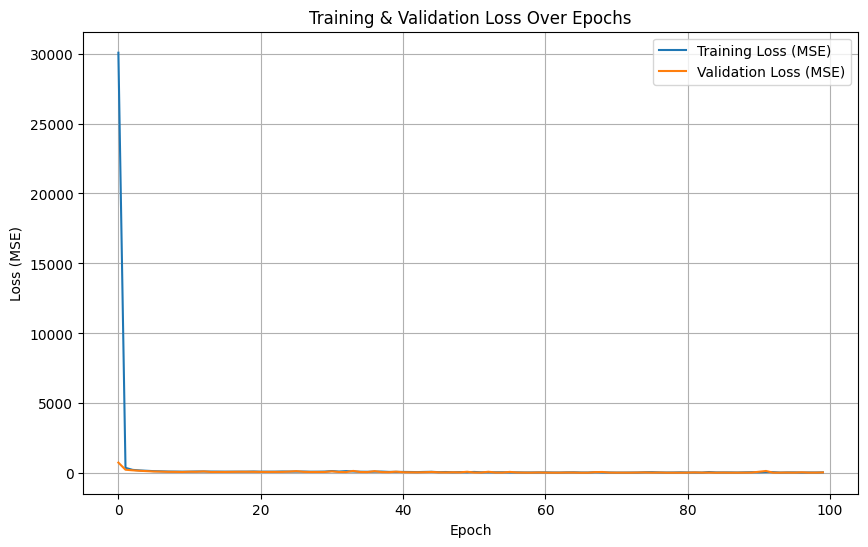


--- Generating Predictions vs. Actuals Plot ---


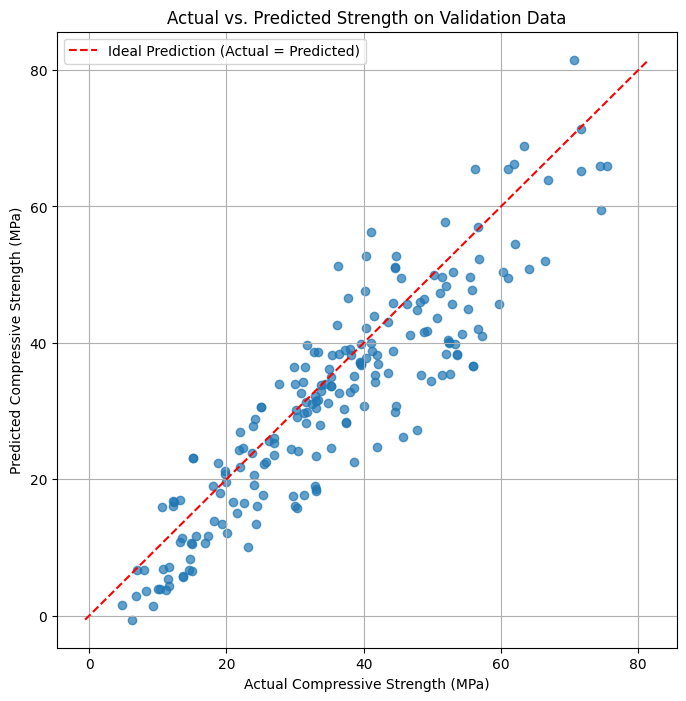


--- Saving and Loading Model ---
Model saved to concrete_strength_predictor_model.pth
Prediction from loaded model (Mix 1): 28.49 MPa


In [11]:
#import the liabraries to be used
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time


df = pd.read_csv('../data/raw/Concrete_Data.csv')
df.head()
df.info()

X_np = np.array(df.drop('concrete_compressive_strength' ,axis =1))
Y_np = np.array(df['concrete_compressive_strength'])

X_train_np,X_val_np,Y_train_np,Y_val_np = train_test_split(X_np,Y_np,test_size = 0.2,random_state = 42)\

X_train_tensor = torch.tensor(X_train_np,dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_np,dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val_np,dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val_np,dtype=torch.float32).unsqueeze(1)

class ConcreteDataset(Dataset):
    
    def __init__(self,features_tensor,labels_tensor):
        self.features = features_tensor
        self.labels = labels_tensor

    def __len__(self):
        return len(self.features)

    def __getitem__(self,idx):
        return self.features[idx],self.labels[idx]

train_dataset = ConcreteDataset(X_train_tensor,Y_train_tensor)     
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)


val_dataset = ConcreteDataset(X_val_tensor,Y_val_tensor)     
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=True)

class ConcreteStrengthPredictor(nn.Module):
    
    def __init__(self,input_features,hidden_size,output_size):
        super().__init__()
        self.input_layer1 = nn.Linear(input_features,hidden_size)
        self.input_layer2 = nn.Linear(hidden_size,output_size)

    def forward(self,x):

        x = self.input_layer1(x)
        x = F.relu(x)
        x = self.input_layer2(x)
        return x


input_features = X_train_tensor.size(1)
hidden_size = 100
output_size = 1
learning_rate = 0.05
epochs = 100 
batch_size = 32


concrete_predictor_model = ConcreteStrengthPredictor(input_features,hidden_size,output_size)


loss_fp = nn.MSELoss()

param = concrete_predictor_model.parameters()
optimizer = torch.optim.Adam( param, lr=learning_rate)


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

concrete_predictor_model.to(device)

# --- Training and Validation Loop ---
print("\nStarting Training for Concrete Strength Predictor...")
train_losses = [] # List to store training loss history
val_losses = []   # List to store validation loss history

for epoch in range(epochs):
    
    concrete_predictor_model.train()
    train_loss=0.0

    for inputs,target in train_loader:
        
        inputs = inputs.to(device)
        target = target.to(device)

        predictions = concrete_predictor_model(inputs)
        loss = loss_fp(predictions,target)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    concrete_predictor_model.eval()

    val_loss = 0 
    with torch.no_grad():

        for inputs,targets in val_loader:

            inputs = inputs.to(device)
            targets = targets.to(device)

            val_predictions = concrete_predictor_model(inputs)
            loss = loss_fp(val_predictions,targets)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader) 
    val_losses.append(avg_val_loss)
    rmse = np.sqrt(avg_val_loss) 

    if epoch == 0 or epoch%10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.2f}, Val Loss: {avg_val_loss:.2f}, Val RMSE: ${rmse:.2f}")


    concrete_predictor_model.train() 

print("\nTraining Finished!")

def predict_strength(cement, slag, flyash, water, superplasticizer,
                     coarseagg, fineagg, age, model, device):
    model.eval()
    input_data = [[cement, slag, flyash, water, superplasticizer, coarseagg, fineagg, age]]
    input_tensor = torch.tensor(input_data, dtype=torch.float32).to(device)

    with torch.no_grad():
        predicted_strength_tensor = model(input_tensor)
        predicted_strength = predicted_strength_tensor.item()
    return predicted_strength

# --- Testing Inference on New Data ---
print("\n--- Testing Inference on New Concrete Mix ---")

# Example new concrete mixes (ensure these are within a reasonable range for the model's training data)
# These values are derived from typical concrete mix design parameters
test_mix1 = [300.0, 0.0, 0.0, 180.0, 0.0, 900.0, 800.0, 28] # Common mix, often 30-40 MPa
test_mix2 = [500.0, 100.0, 50.0, 160.0, 10.0, 1000.0, 600.0, 90] # Stronger mix
test_mix3 = [200.0, 0.0, 0.0, 200.0, 0.0, 1000.0, 900.0, 7] # Weaker mix, younger age

# Call the function to predict strength for each mix
# The * before test_mix1 unpacks the list into separate arguments for the function
predicted_strength1 = predict_strength(*test_mix1, concrete_predictor_model, device)
print(f"Mix 1 (C:{test_mix1[0]}, W:{test_mix1[3]}, A:{test_mix1[7]}) -> Predicted Strength: {predicted_strength1:.2f} MPa")

predicted_strength2 = predict_strength(*test_mix2, concrete_predictor_model, device)
print(f"Mix 2 (C:{test_mix2[0]}, W:{test_mix2[3]}, A:{test_mix2[7]}) -> Predicted Strength: {predicted_strength2:.2f} MPa")

predicted_strength3 = predict_strength(*test_mix3, concrete_predictor_model, device)
print(f"Mix 3 (C:{test_mix3[0]}, W:{test_mix3[3]}, A:{test_mix3[7]}) -> Predicted Strength: {predicted_strength3:.2f} MPa")


# --- Plotting Training & Validation Loss ---
print("\n--- Generating Loss Plot ---")
plt.figure(figsize=(10, 6))
# Remember to store train_losses and val_losses as lists initialized before the epoch loop!
# e.g., train_losses = []; val_losses = []
# And append: train_losses.append(avg_train_loss); val_losses.append(avg_val_loss)
plt.plot(range(epochs), train_losses, label='Training Loss (MSE)')
plt.plot(range(epochs), val_losses, label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


# --- Plotting Predictions vs. Actuals for Validation Data ---
print("\n--- Generating Predictions vs. Actuals Plot ---")
concrete_predictor_model.eval() # Ensure model is in eval mode
val_preds_list = []
val_targets_list = []
with torch.no_grad():
    for inputs, targets in val_loader: # Use val_loader for actual vs. predicted plot
        inputs, targets = inputs.to(device), targets.to(device)
        predictions = concrete_predictor_model(inputs)
        val_preds_list.extend(predictions.cpu().numpy()) # Move to CPU and convert to NumPy
        val_targets_list.extend(targets.cpu().numpy()) # Move to CPU and convert to NumPy

plt.figure(figsize=(8, 8))
# Convert lists of arrays/tensors to single 1D NumPy arrays for scatter plot
val_preds_1d = np.array(val_preds_list).flatten()
val_targets_1d = np.array(val_targets_list).flatten()

plt.scatter(val_targets_1d, val_preds_1d, alpha=0.7)
# Plot ideal line (where y=x)
min_val = min(val_targets_1d.min(), val_preds_1d.min())
max_val = max(val_targets_1d.max(), val_preds_1d.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Prediction (Actual = Predicted)')
plt.xlabel('Actual Compressive Strength (MPa)')
plt.ylabel('Predicted Compressive Strength (MPa)')
plt.title('Actual vs. Predicted Strength on Validation Data')
plt.grid(True)
plt.legend()
plt.show()


# --- Model Saving and Loading ---
print("\n--- Saving and Loading Model ---")
MODEL_SAVE_PATH = "concrete_strength_predictor_model.pth"

# Save the model's state dictionary
torch.save(concrete_predictor_model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

# To load the model, you need to re-instantiate the model class first
loaded_model = ConcreteStrengthPredictor(input_features, hidden_size, output_size) # Use corrected input_features
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model.to(device) # Move loaded model to the correct device
loaded_model.eval() # Set to eval mode

# Test prediction with the loaded model
test_loaded_strength = predict_strength(*test_mix1, loaded_model, device)
print(f"Prediction from loaded model (Mix 1): {test_loaded_strength:.2f} MPa")
